In [4]:
import numpy as np
import pandas as pd
import re
import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def limpar_texto(texto):
    texto = texto.lower()  # Converte tudo para minúsculas
    texto = re.sub(r'[^\w\s]', ' ', texto)  # Remove pontuações
    texto = re.sub(r'\d+', ' ', texto)      # Remove números
    texto = re.sub(r'\s+', ' ', texto)      # Substitui múltiplos espaços por um só
    return texto.strip()

In [6]:
texto_demo = """
A modelagem de linguagem natural é uma técnica importante no processamento de linguagem natural.
Os modelos de linguagem podem ser usados para prever a próxima palavra em uma sequência.
Existem diversos tipos de modelos de linguagem, incluindo modelos baseados em N-grams e modelos neurais.
Os modelos baseados em N-grams são mais simples, mas ainda muito úteis em diversas aplicações.
"""

In [7]:
texto_tratado = limpar_texto(texto_demo)
print(texto_tratado)

a modelagem de linguagem natural é uma técnica importante no processamento de linguagem natural os modelos de linguagem podem ser usados para prever a próxima palavra em uma sequência existem diversos tipos de modelos de linguagem incluindo modelos baseados em n grams e modelos neurais os modelos baseados em n grams são mais simples mas ainda muito úteis em diversas aplicações


In [8]:
palavras = limpar_texto(texto_demo).split()
print("Quantidade de palavras:", len(palavras))
print("Exemplo:", palavras[:10])

Quantidade de palavras: 61
Exemplo: ['a', 'modelagem', 'de', 'linguagem', 'natural', 'é', 'uma', 'técnica', 'importante', 'no']


In [9]:
class ModeloNGram:
    def __init__(self, n):
        self.n = n
        self.contagens = defaultdict(Counter)
        self.modelo = {}

    def treinar(self, palavras):
        for i in range(len(palavras) - self.n + 1):
            contexto = tuple(palavras[i:i+self.n-1])
            alvo = palavras[i+self.n-1]
            self.contagens[contexto][alvo] += 1

        for contexto, alvos in self.contagens.items():
            total = sum(alvos.values())
            self.modelo[contexto] = {
                palavra: freq / total for palavra, freq in alvos.items()
            }

    def proxima_palavra(self, contexto):
        contexto = tuple(contexto[-(self.n-1):]) if self.n > 1 else ()
        if contexto in self.modelo:
            palavras = list(self.modelo[contexto].keys())
            probs = list(self.modelo[contexto].values())
            return np.random.choice(palavras, p=probs)
        return None

    def gerar_texto(self, contexto_inicial, quantidade=15):
        if isinstance(contexto_inicial, str):
            contexto_inicial = contexto_inicial.split()
        if len(contexto_inicial) < self.n - 1:
            raise ValueError(f"Contexto inicial deve ter pelo menos {self.n - 1} palavras")
        texto = list(contexto_inicial)
        for _ in range(quantidade):
            prox = self.proxima_palavra(texto)
            if not prox:
                break
            texto.append(prox)
        return ' '.join(texto)

In [40]:
modelo_1gram = ModeloNGram(1)
modelo_2gram = ModeloNGram(2)
modelo_3gram = ModeloNGram(3)
modelo_7gram = ModeloNGram(7)

modelo_1gram.treinar(palavras)
modelo_2gram.treinar(palavras)
modelo_3gram.treinar(palavras)
modelo_7gram.treinar(palavras)

In [43]:
def calcular_perplexidade(modelo, texto_teste):
    tokens = limpar_texto(texto_teste).split()
    log_prob = 0
    total = 0
    for i in range(modelo.n - 1, len(tokens)):
        contexto = tuple(tokens[i - modelo.n + 1:i]) if modelo.n > 1 else ()
        alvo = tokens[i]
        prob = modelo.modelo.get(contexto, {}).get(alvo, 1e-10)
        log_prob += np.log2(prob)
        total += 1
    return 2 ** (-log_prob / total) if total > 0 else float('inf')

texto_teste = """
Os modelos de linguagem são fundamentais para diversas aplicações.
A modelagem estatística ajuda a entender padrões em textos.
"""

print("Perplexidade:")
print("Unigram:", calcular_perplexidade(modelo_1gram, texto_teste))
print("Bigram:", calcular_perplexidade(modelo_2gram, texto_teste))
print("Septagram:", calcular_perplexidade(modelo_7gram, texto_teste))

Perplexidade:
Unigram: 9999999999.999958
Bigram: 10000000000.000008
Septagram: 10000000000.000008


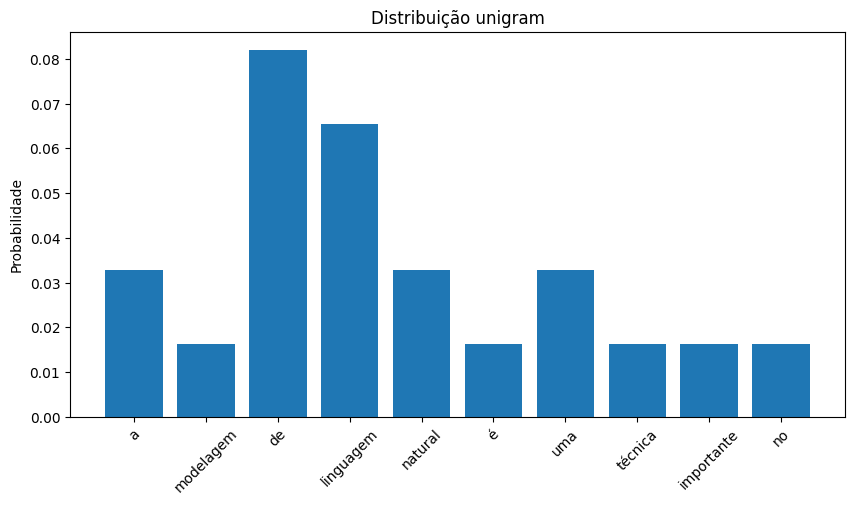

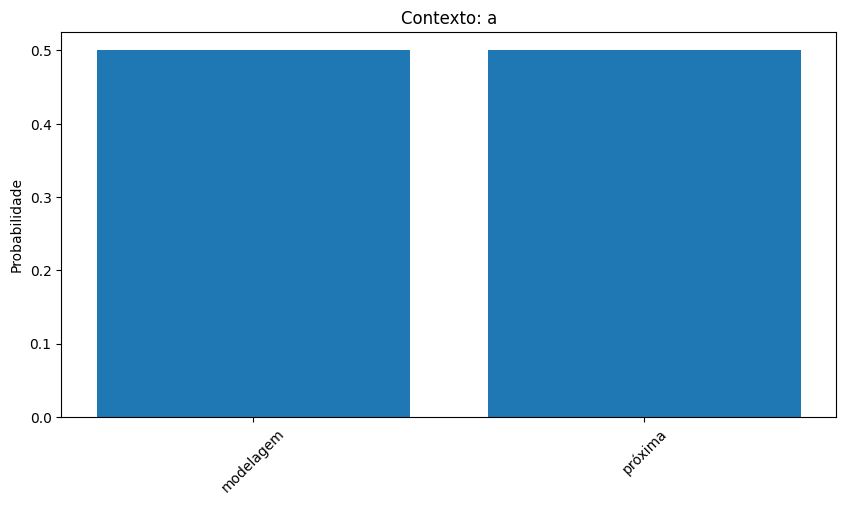

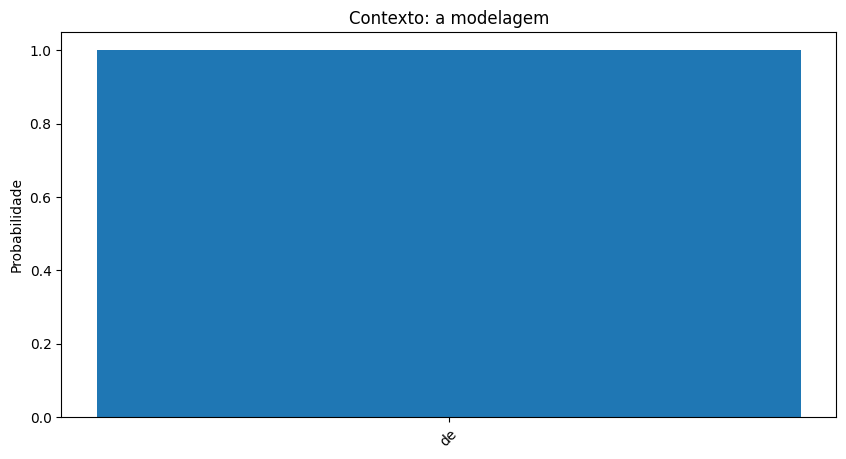

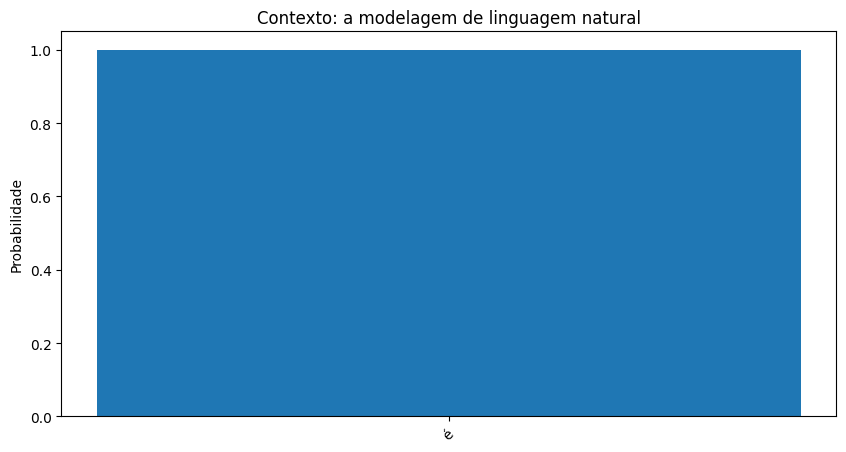

In [12]:
def mostrar_distribuicao(modelo, contexto=None):
    if modelo.n == 1:
        contexto = ()
    if contexto is None or contexto not in modelo.modelo:
        contexto = list(modelo.modelo.keys())[0]
    palavras = list(modelo.modelo[contexto].keys())
    probs = list(modelo.modelo[contexto].values())
    plt.figure(figsize=(10,5))
    plt.bar(palavras[:10], probs[:10])
    titulo = "Distribuição unigram" if modelo.n == 1 else f"Contexto: {' '.join(contexto)}"
    plt.title(titulo)
    plt.ylabel("Probabilidade")
    plt.xticks(rotation=45)
    plt.show()

mostrar_distribuicao(modelo_1gram)
mostrar_distribuicao(modelo_2gram)
mostrar_distribuicao(modelo_3gram)
mostrar_distribuicao(modelo_7gram)

In [13]:
def distancia_edicao(s1, s2):
    if len(s1) < len(s2):
        return distancia_edicao(s2, s1)
    if len(s2) == 0:
        return len(s1)
    anterior = list(range(len(s2) + 1))
    for i, c1 in enumerate(s1):
        atual = [i + 1]
        for j, c2 in enumerate(s2):
            custos = [
                anterior[j + 1] + 1,
                atual[j] + 1,
                anterior[j] + (c1 != c2)
            ]
            atual.append(min(custos))
        anterior = atual
    return anterior[-1]

def sugerir_palavra(palavra, modelo):
    if palavra in modelo.modelo[()]:
        return palavra
    candidatos = []
    for voc in modelo.modelo[()]:
        dist = distancia_edicao(palavra, voc)
        if dist <= 2:
            prob = modelo.modelo[()].get(voc, 0)
            candidatos.append((voc, dist, prob))
    if not candidatos:
        return palavra
    candidatos.sort(key=lambda x: (x[1], -x[2]))
    return candidatos[0][0]

In [14]:
palavras_erradas = ["modelgem", "linguaem", "natual", "processment"]
print("Correções sugeridas:")
for erro in palavras_erradas:
    print(f"{erro} → {sugerir_palavra(erro, modelo_1gram)}")

Correções sugeridas:
modelgem → modelagem
linguaem → linguagem
natual → natural
processment → processamento


In [50]:
print("Textos gerados:")
print("Unigram:", modelo_1gram.gerar_texto([], 30))
print("Bigram:", modelo_2gram.gerar_texto(["linguagem"], 15))
print("Trigram:", modelo_3gram.gerar_texto(["modelos", "de"], 50))
print("Septagram:", modelo_7gram.gerar_texto(["os", "modelos", "de", "linguagem", "podem", "ser"], 100))

Textos gerados:
Unigram: 
Bigram: linguagem
Trigram: modelos de
Septagram: os modelos de linguagem podem ser


In [47]:
with open("tema.txt", "r", encoding="utf-8") as arquivo:
    texto_lido = arquivo.read()

texto_tratado = limpar_texto(texto_lido)
palavras_do_tema = texto_tratado.split()

print("Quantidades de palavras:", len(palavras_do_tema))
print("Exemplo:", palavras[:20])


Quantidades de palavras: 178
Exemplo: []


In [51]:
modelo_7gram = ModeloNGram(6)

modelo_7gram.treinar(palavras_do_tema)

In [54]:
print("Textos gerados:")
print("Unigram:", modelo_1gram.gerar_texto([], 10))
print("Bigram:", modelo_2gram.gerar_texto(["linguagem"], 50))
print("Trigram:", modelo_3gram.gerar_texto(["modelos", "de"], 25))
print("7gram:", modelo_7gram.gerar_texto(["a", "inteligência", "artificial", "está", "presente", "em"], 100))



Textos gerados:
Unigram: 
Bigram: linguagem
Trigram: modelos de
7gram: a inteligência artificial está presente em
